In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import math
import numpy as np

In [2]:
TRAIN_DATA_DIR = './cats_and_dogs_small/train'
VALIDATION_DATA_DIR = './cats_and_dogs_small/validation'
TEST_DATA_DIR = './cats_and_dogs_small/test'

TRAIN_SAMPLES = 800*2
VALIDATION_SAMPLES = 400*2 
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# We don't augment data for validation dataset!

In [4]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 1600 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [5]:
model = VGG16(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
def model_maker():
    base_model = VGG16(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    print(len(base_model.layers))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(32, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [8]:
model_final = model_maker()
model_final.summary()

19
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 14,731,170
Trainable params: 16,482
Non-trainable params: 14,714,688
_______________________________________

In [9]:
model_final.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
history = model_final.fit(
    train_generator,
    steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE, # number of updates
    epochs=10,
    validation_data=validation_generator,
    validation_steps=VALIDATION_SAMPLES // BATCH_SIZE)

Epoch 1/10
25/25 [==============================] - 19s 777ms/step - loss: 1.2311 - acc: 0.7469 - val_loss: 0.1167 - val_acc: 0.9531
Epoch 2/10
25/25 [==============================] - 20s 783ms/step - loss: 0.2196 - acc: 0.9094 - val_loss: 0.0883 - val_acc: 0.9648
Epoch 3/10
25/25 [==============================] - 19s 777ms/step - loss: 0.1795 - acc: 0.9231 - val_loss: 0.0775 - val_acc: 0.9701
Epoch 4/10
25/25 [==============================] - 19s 765ms/step - loss: 0.1429 - acc: 0.9394 - val_loss: 0.0849 - val_acc: 0.9622
Epoch 5/10
25/25 [==============================] - 19s 766ms/step - loss: 0.1330 - acc: 0.9438 - val_loss: 0.0910 - val_acc: 0.9609
Epoch 6/10
25/25 [==============================] - 19s 759ms/step - loss: 0.1283 - acc: 0.9481 - val_loss: 0.0751 - val_acc: 0.9701
Epoch 7/10
25/25 [==============================] - 19s 763ms/step - loss: 0.0970 - acc: 0.9519 - val_loss: 0.0707 - val_acc: 0.9714
Epoch 8/10
25/25 [==============================] - 19s 773ms/step - 

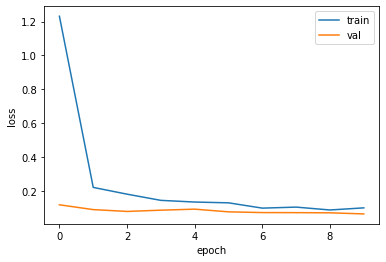

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

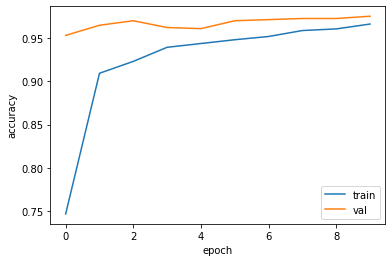

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [13]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 800 images belonging to 2 classes.


In [15]:
model_final.evaluate(test_generator, steps=800 // BATCH_SIZE,verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
12/12 [==============================] - 3s 253ms/step - loss: 0.0511 - acc: 0.9779


[0.05105483531951904, 0.9778645634651184]

In [16]:
np.set_printoptions(suppress=True)

In [17]:
img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255.  # Preprocess the image
prediction = model_final.predict(preprocessed_img)
print(np.array(prediction[0]))
# print(validation_generator.class_indices)

[0.68213856 0.31786144]
